In [2]:
from google.colab import files
uploaded = files.upload()


Saving gme_tweets.csv to gme_tweets.csv


In [13]:
!pip install vaderSentiment

import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Loading csv w/o header and skip bad lines
tweets_df = pd.read_csv(next(iter(uploaded.keys())), header=None, on_bad_lines='skip')

# change column names
tweets_df.columns = ['id', 'source', 'company', 'text', 'likes', 'date']

# just twitter data
tweets_df = tweets_df[tweets_df['source'].str.lower() == 'twitter']

# just Nvidia tweets
nvidia_tweets = tweets_df[tweets_df['company'].str.lower() == 'nvidia']

In [16]:
# preprocess tweets
def clean_tweet(tweet):
    if isinstance(tweet, str):
        tweet = tweet.lower()
        tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
        tweet = re.sub(r'\@\w+|\#', '', tweet)
        tweet = re.sub(r'[^a-zA-Z\s]', ' ', tweet)
        tweet = tweet.strip()
        return tweet
    else:
        return ""

In [17]:
# cleaning tweet text
nvidia_tweets['cleaned_text'] = nvidia_tweets['text'].apply(clean_tweet)

<ipython-input-17-dd9d818cb688>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_tweets['cleaned_text'] = nvidia_tweets['text'].apply(clean_tweet)


In [47]:
# vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# sentiment analysis using vader
nvidia_tweets['sentiment_score'] = nvidia_tweets['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# date column to datetime
nvidia_tweets['date'] = pd.to_datetime(nvidia_tweets['date'], errors='coerce').dt.date

# removing rows with invalid dates
nvidia_tweets = nvidia_tweets.dropna(subset=['date'])

# calcu;ating daily average sentiment scores
daily_sentiment = nvidia_tweets.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['date', 'average_sentiment']

# print daily sentiment averages and individual sentiment scores
print("Daily Average Sentiment Scores:")
print(daily_sentiment)

print("\nIndividual Sentiment Scores:")
print(nvidia_tweets[['date', 'sentiment_score']])

Daily Average Sentiment Scores:
           date  average_sentiment
0    2022-07-01           0.085773
1    2022-07-02           0.108914
2    2022-07-03           0.103881
3    2022-07-04           0.090361
4    2022-07-05           0.142103
..          ...                ...
752  2024-07-23           0.175344
753  2024-07-24           0.112557
754  2024-07-25           0.062924
755  2024-07-26           0.136293
756  2024-07-27           0.152522

[757 rows x 2 columns]

Individual Sentiment Scores:
              date  sentiment_score
215     2022-08-15           0.4754
428     2023-08-06           0.0000
8468    2022-07-08           0.0000
8751    2022-07-21           0.0000
8797    2022-09-11           0.5719
...            ...              ...
357894  2024-07-27           0.5859
357895  2024-07-27           0.8750
357896  2024-07-27           0.0000
357897  2024-07-27          -0.2263
357899  2024-07-27           0.3612

[195920 rows x 2 columns]


In [19]:

stock_uploaded = files.upload()

# loading nvidia's stock price
stock_data = pd.read_csv(next(iter(stock_uploaded.keys())))


Saving NVDA.csv to NVDA.csv


In [21]:
# columns and first few rows
print("Stock DataFrame columns:", stock_data.columns)
print(stock_data.head())

Stock DataFrame columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
         Date       Open       High        Low      Close  Adj Close  \
0  2019-04-01  45.814999  48.367500  43.325001  45.250000  44.942688   
1  2019-05-01  45.777500  46.217499  33.847500  33.865002  33.635014   
2  2019-06-01  33.977501  41.342499  33.150002  41.057499  40.825203   
3  2019-07-01  43.142502  44.722500  38.750000  42.180000  41.941360   
4  2019-08-01  42.285000  43.362499  36.847500  41.877499  41.640560   

         Volume  
0  9.437780e+08  
1  1.118075e+09  
2  8.233340e+08  
3  8.415984e+08  
4  9.450328e+08  


In [24]:
# convertibg date column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# few rows to check conversion
print(stock_data[['Date', 'Close']].head())

         Date      Close
0  2019-04-01  45.250000
1  2019-05-01  33.865002
2  2019-06-01  41.057499
3  2019-07-01  42.180000
4  2019-08-01  41.877499


In [29]:
#  rename to match tweets_df
stock_data.rename(columns={'Date': 'date'}, inplace=True)

# check date conversion
print(stock_data[['date', 'Close']].head())

# merging sentiment scores with the stock price
merged_data = pd.merge(daily_sentiment, stock_data, on='date')

# verify merged DataFrame
print("Merged DataFrame columns:", merged_data.columns)
print(merged_data.head())

         date      Close
0  2019-04-01  45.250000
1  2019-05-01  33.865002
2  2019-06-01  41.057499
3  2019-07-01  42.180000
4  2019-08-01  41.877499
Merged DataFrame columns: Index(['date', 'average_sentiment', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume'],
      dtype='object')
         date  average_sentiment        Open        High         Low  \
0  2022-07-01           0.085773  148.990005  182.440002  140.550003   
1  2022-08-01           0.154387  181.820007  192.740005  149.589996   
2  2022-09-01           0.038721  142.089996  145.470001  119.459999   
3  2022-10-01           0.223400  123.470001  138.500000  108.129997   
4  2022-11-01           0.245248  138.110001  169.979996  129.559998   

        Close   Adj Close        Volume  
0  181.630005  181.440567  1.056448e+09  
1  150.940002  150.782578  1.206965e+09  
2  121.389999  121.263397  1.313058e+09  
3  134.970001  134.869293  1.254928e+09  
4  169.229996  169.103729  1.060060e+09  


In [31]:
# correlation b/w sentiment and stock prices
correlation = merged_data['average_sentiment'].corr(merged_data['Close'])
print(f'Correlation between sentiment and Nvidia stock price: {correlation}')

Correlation between sentiment and Nvidia stock price: 0.34213728341307154


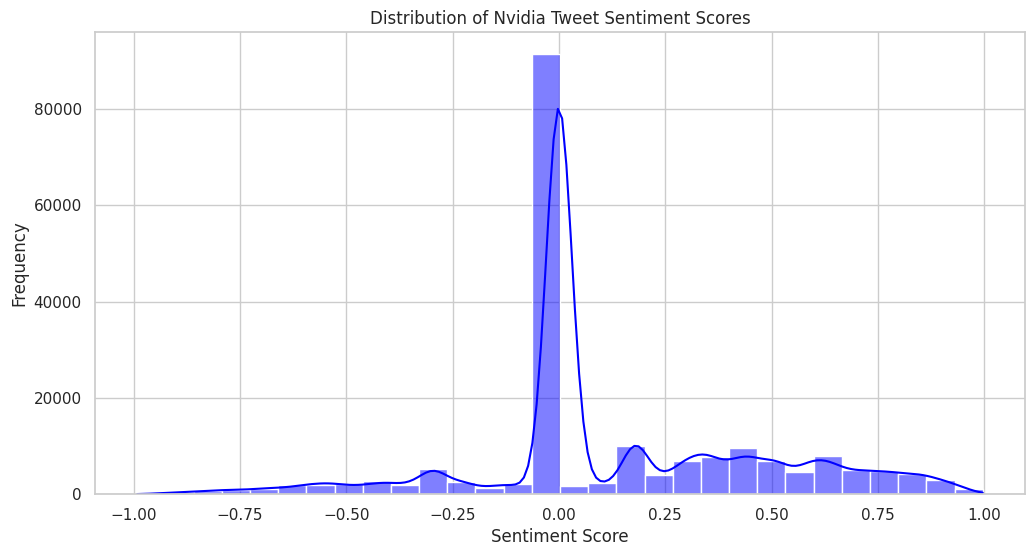

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# style
sns.set(style="whitegrid")

# 1. Sentiment Score Distribution
plt.figure(figsize=(12, 6))
sns.histplot(nvidia_tweets['sentiment_score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Nvidia Tweet Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()




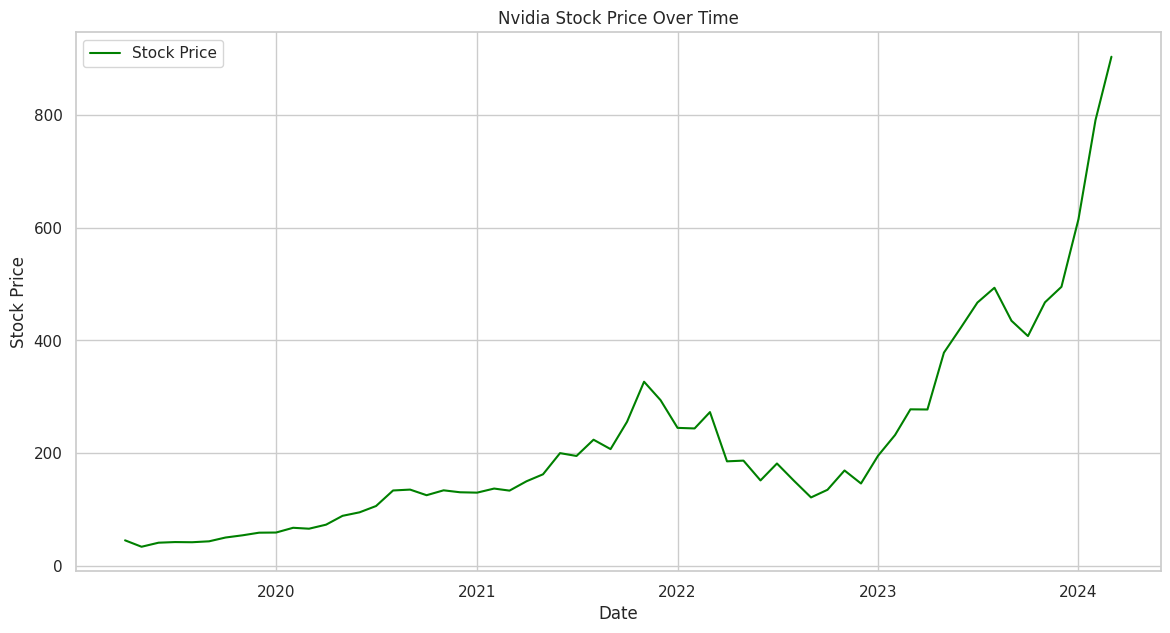

In [36]:
# 2. Nvidia Stock Price Over Time
plt.figure(figsize=(14, 7))
plt.plot(stock_data['date'], stock_data['Close'], color='green', label='Stock Price')
plt.title('Nvidia Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()



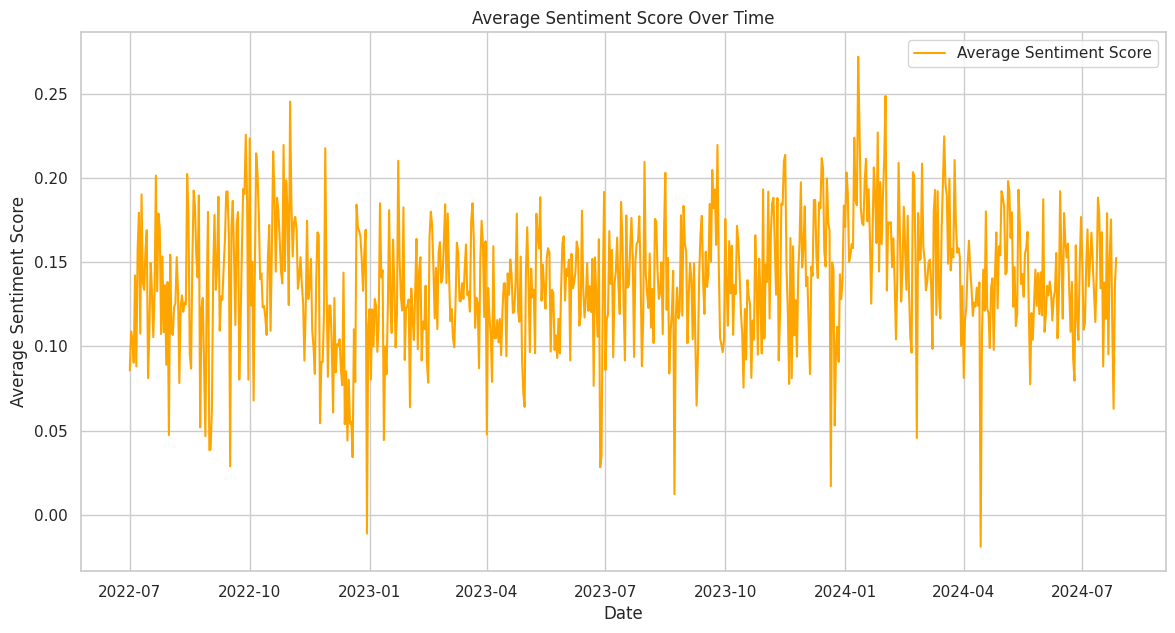

In [37]:
# 3. Average Sentiment Score Over Time
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment['date'], daily_sentiment['average_sentiment'], color='orange', label='Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

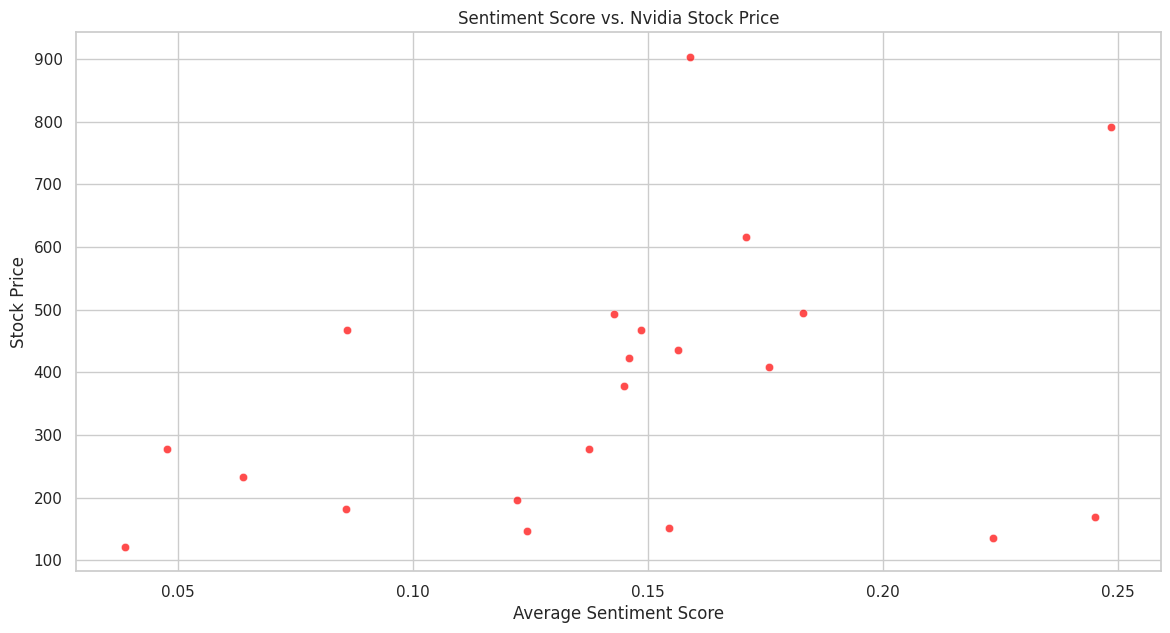

In [38]:
# 4. Sentiment vs. Stock Price
plt.figure(figsize=(14, 7))
sns.scatterplot(data=merged_data, x='average_sentiment', y='Close', color='red', alpha=0.7)
plt.title('Sentiment Score vs. Nvidia Stock Price')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

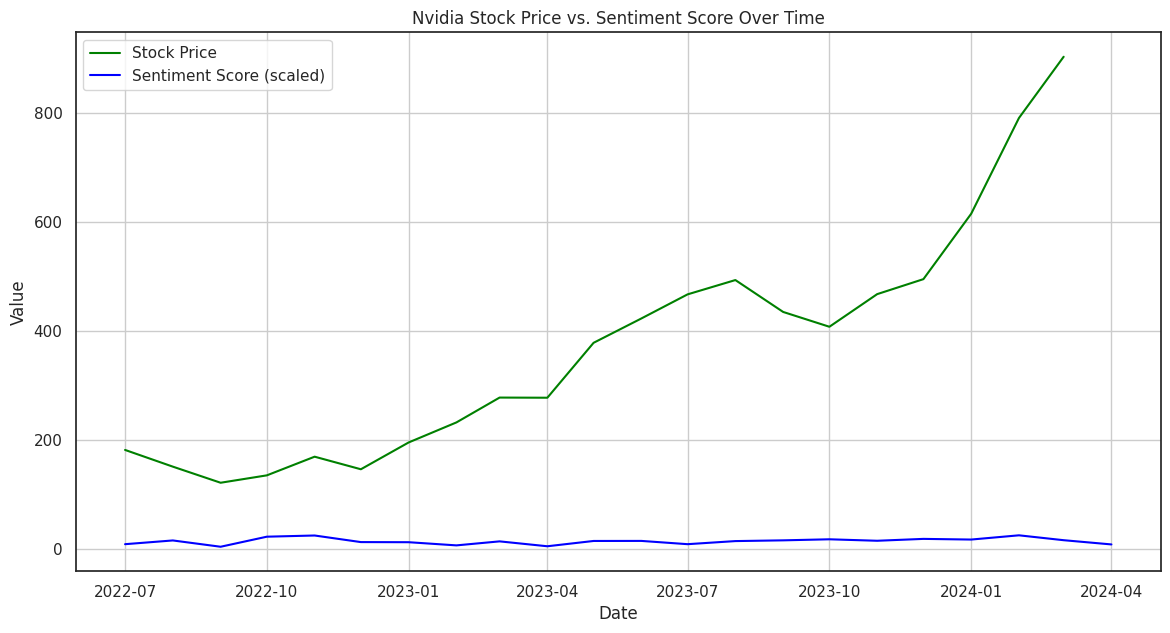

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# date column is in datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# style
sns.set(style="white")

# figure and axis
plt.figure(figsize=(14, 7))

# graph
plt.plot(merged_data['date'], merged_data['Close'], color='green', label='Stock Price')
plt.plot(merged_data['date'], merged_data['average_sentiment'] * 100, color='blue', label='Sentiment Score (scaled)')

# title and labels
plt.title('Nvidia Stock Price vs. Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# print
plt.show()
